# Whitening: Z-Scoring vs PCA vs ZCA

We contrast simple per-feature normalization with full whitening. Whitening is
central to ICA because it reduces the remaining mixing matrix to an orthogonal
transform, simplifying source separation.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

TOPIC = "whitening"
FIG_DIR = os.path.join("figures", TOPIC)
os.makedirs(FIG_DIR, exist_ok=True)

rng = np.random.default_rng(123)

## Generate correlated Gaussian data

The cloud has elongated covariance, giving us something to decorrelate.

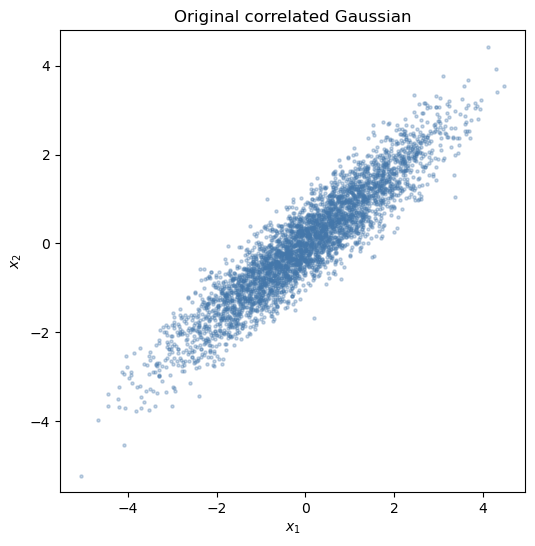

Covariance of original data:
 [[2.032 1.626]
 [1.626 1.519]]


In [2]:
n_samples = 4000
cov = np.array([[2.0, 1.6], [1.6, 1.5]])
L = np.linalg.cholesky(cov)
Z = rng.standard_normal((2, n_samples))
X = (L @ Z).T  # shape (n_samples, 2)

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], s=5, alpha=0.3, color="#4477aa")
plt.title("Original correlated Gaussian")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.axis("equal")
plt.savefig(
    os.path.join(FIG_DIR, "original_correlated_gaussian.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()

print("Covariance of original data:\n", np.round(np.cov(X, rowvar=False), 3))

## Z-scoring (per-feature standardization)

Z-scoring normalizes marginal variances but does **not** remove correlations.

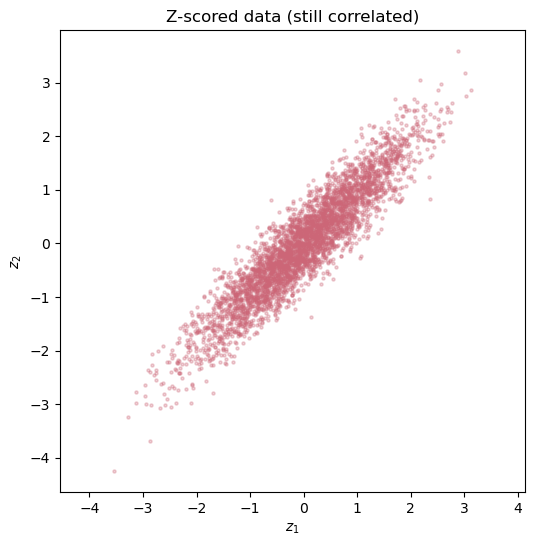

Covariance after z-scoring:
 [[1.    0.926]
 [0.926 1.   ]]


In [3]:
mean = X.mean(axis=0, keepdims=True)
std = X.std(axis=0, keepdims=True)
X_z = (X - mean) / std

plt.figure(figsize=(6, 6))
plt.scatter(X_z[:, 0], X_z[:, 1], s=5, alpha=0.3, color="#cc6677")
plt.title("Z-scored data (still correlated)")
plt.xlabel("$z_1$")
plt.ylabel("$z_2$")
plt.axis("equal")
plt.savefig(
    os.path.join(FIG_DIR, "zscored_data.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()

print("Covariance after z-scoring:\n", np.round(np.cov(X_z, rowvar=False), 3))

## PCA whitening

Rotate into the eigenbasis and scale so variances become 1.

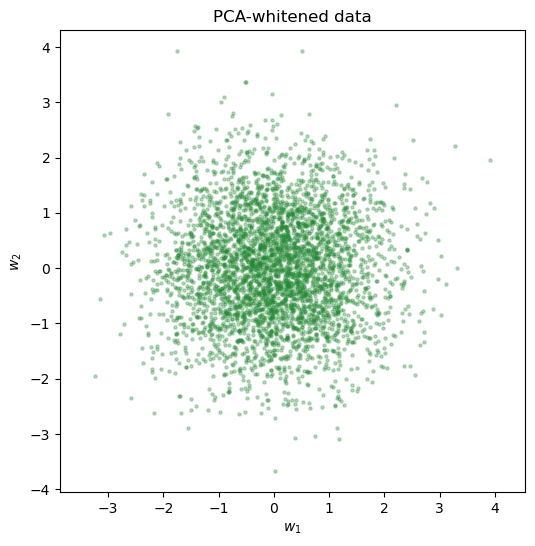

Covariance after PCA whitening:
 [[ 1. -0.]
 [-0.  1.]]


In [4]:
X_centered = X - mean
cov_centered = np.cov(X_centered, rowvar=False)
eigvals, eigvecs = np.linalg.eigh(cov_centered)
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

eps = 1e-6
Lambda_inv_sqrt = np.diag(1.0 / np.sqrt(eigvals + eps))
V_pca = Lambda_inv_sqrt @ eigvecs.T
X_pca = (V_pca @ X_centered.T).T

plt.figure(figsize=(6, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=5, alpha=0.3, color="#228833")
plt.title("PCA-whitened data")
plt.xlabel("$w_1$")
plt.ylabel("$w_2$")
plt.axis("equal")
plt.savefig(
    os.path.join(FIG_DIR, "pca_whitened.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()

print("Covariance after PCA whitening:\n", np.round(np.cov(X_pca, rowvar=False), 3))

## ZCA whitening

ZCA whitening decorrelates while staying as close as possible to the original
axes, making the cloud look “unrotated.”

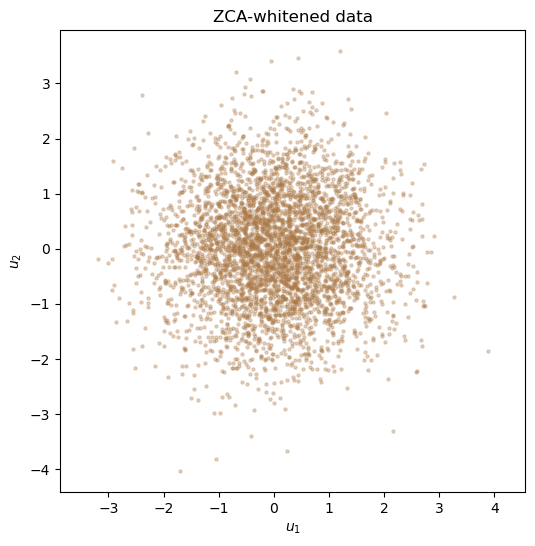

Covariance after ZCA whitening:
 [[1. 0.]
 [0. 1.]]


In [5]:
V_zca = eigvecs @ Lambda_inv_sqrt @ eigvecs.T
X_zca = (V_zca @ X_centered.T).T

plt.figure(figsize=(6, 6))
plt.scatter(X_zca[:, 0], X_zca[:, 1], s=5, alpha=0.3, color="#aa7744")
plt.title("ZCA-whitened data")
plt.xlabel("$u_1$")
plt.ylabel("$u_2$")
plt.axis("equal")
plt.savefig(
    os.path.join(FIG_DIR, "zca_whitened.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()

print("Covariance after ZCA whitening:\n", np.round(np.cov(X_zca, rowvar=False), 3))

## Takeaways for ICA

* Z-scoring alone leaves correlations intact.
* PCA whitening rotates into the eigenbasis before scaling.
* ZCA whitening keeps the orientation intuitive yet still achieves identity
  covariance.
* Whitening shrinks ICA's search space to orthogonal rotations, speeding up
  recovery of independent components.